# クラスタリングしてみよう

クラスタリング（clustering）とは、データ間の類似度にもとづいて、データをグループ分けする手法です。
データ分析のはじめにデータの特徴を把握するために活用されます。
また、機械学習アルゴリズムとしても __教師なし学習__ として重要です。

今回は、代表的なクラスタリングアルゴリズムをハンズオン演習しながら、
クラスタリングを行う技法を学んでいきましょう。

__モジュールの準備__


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import japanize_matplotlib #日本語化 matplotlib 
except ModuleNotFoundError:
    !pip install japanize_matplotlib
    import japanize_matplotlib 
sns.set(font="IPAexGothic") #日本語フォント設定


## クラスタリング

クラスタリングとは、データ間の類似度にもとづいて、データをグループ分けする手法です。クラスタリングによってできた、似たもの同士が集まったグループのことをクラスタと呼びます。

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" width="80%" align="center">

__活用例__

* 顧客のセグメンテーション
* 学生をグループ分け
* テキストマイニング
* 画像の分類

「データ間の類似度にもとづいてデータをグループ分けする」という特徴の活かし方次第で、さまざまな問題に応用できます。

<!--
### クラスタリングの種類
-->




### K-means法 (K-平均法)

**K-means法**は、クラスタリングで最も広く使われている手法です。
非階層型クラスタリングのアルゴリズであり、クラスタの平均を用い、与えられたクラスタ数$k$個に分類します。

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" width="50%" align="center"/>

原理：k-means法は、$n$次元のデータを$k$個のクラスタに分割する。

1. ランダムに$k$個クラスタの重心点（$n$次元ベクトル）$V_{1},\dotsc ,V_{k}$をおく
2. 各データに対し、クラスタと最も近いものをクラスタ所属とする。
3. 全てのデータに対して、クラスタ番号が決まったのち、それぞれのクラスタの重心（平均）を計算し、新しいクラスタの重心点ととする。
4. 重心移動距離が十分に小さくなるまで、2 と 3 を繰り返す。

$$
{\displaystyle \operatorname {arg\,min} _{V_{1},\dotsc ,V_{k}}\sum _{i=1}^{n}\min _{j}\left\|x_{i}-V_{j}\right\|^{2}}
$$

結果は、最初のクラスタのランダムな割り振りに大きく依存します。何度か繰り返して行って最良の結果を選択する手法や、**k-means++法**のように最初のクラスタ中心点の振り方を工夫する手法などが使用されることがあります。

sklearn では、KMeans クラスをインポートして利用できます。

```python
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
```


### 主成分分析(PCA)

**主成分分析（principal component analysis; PCA）**は、相関のある多数の変数から相関のない少数で全体のばらつきを最もよく表す主成分と呼ばれる変数を合成する多変量解析の一手法です。

原理：主成分を与える変換は、第一主成分の分散を最大化し、観測値の変化に対する説明能力を可能な限り主成分に持たせます。続く主成分はそれまでに決定した主成分と直交するという拘束条件の下で分散を最大化するようにして選びます。

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg" width="50%" align="center" />

用途：主成分分析は、**データの次元を削減する**ときの定番的手法です。特に、次元数の多いデータを可視化するとき、主成分分析によってより２次元や３次元に集約することで可視化が容易になります。

sklearn では、PCAクラスをインポートして利用できます。

```python
from sklearn.decomposition import PCA
model = PCA(n_components=2)
```



## 身長と体重からクラスタリング

ここからは、sklearn モジュールの K-means法アルゴリズムを使いながら、
実際にクラスタリングを行っていきます。

<img src="https://miro.medium.com/max/12094/1*IXGsBrC9FnSHGJVw9lDhQA.png" width="40%" align="center"/>



### データ用意と確認

データは、第４回目のコースワークで作成したスポーツ選手の身長と体重を集計した表データを用いてみます。
自分で集計したデータをそのまま利用しても構いませんが、
一応、以下の通り、ダウンロードもできます。

```
!wget https://KuramitsuLab.github.io/data/bmi.csv
```

まず、pandasを使って表データの内容を確認しましょう。


In [2]:
data = pd.read_csv('bmi.csv')
data.head()

,名前,身長,体重,職業
0,福井 優也,178.0,85.0,B
1,九里 亜蓮,187.0,92.0,B
2,加藤 拓也,176.0,88.0,B
3,大瀬良 大地,187.0,93.0,B
4,今村 猛,183.0,98.0,B


### 散布図でデータを確認

身長と体重の分布の様子を散布図とヒストグラムで表示して見ましょう。


__散布図__

データは、あらかじめ職業としてクラス分類されているため、
職業ごとに色分けして散布図を書いてみます。
後から、K-means法でクラスタリングした結果も描画しますので、比べてみましょう。

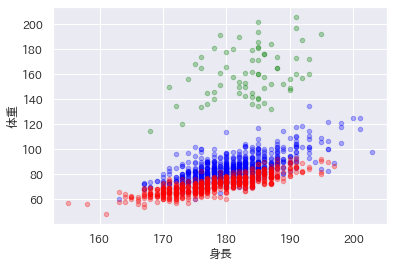

In [3]:
colors = ['blue', 'red', 'green']
ax = None
for i, group in enumerate(data.groupby('職業')):
  ax = group[1].plot(kind='scatter', x='身長', y='体重', alpha=0.3, c=colors[int(i)], ax=ax)

重なり具合を確かめるため、ヒストグラムをみて見ましょう。

* 身長は、全ての色が重なっています。
* 体重は、重なっていない部分があります。

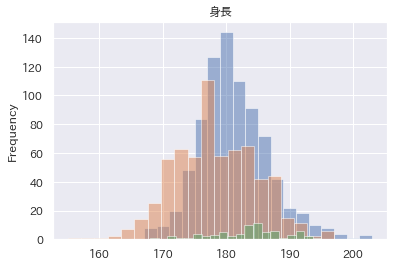

In [4]:
for i, group in enumerate(data.groupby('職業')):
  group[1]['身長'].plot(kind='hist', alpha=0.5, bins=20, title='身長')


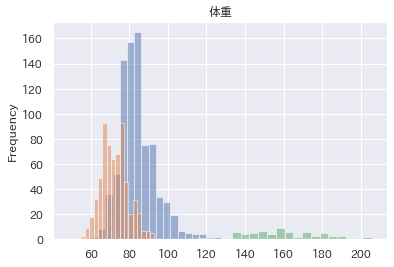

In [5]:
for i, group in enumerate(data.groupby('職業')):
  group[1]['体重'].plot(kind='hist', alpha=0.5, bins=20, title='体重')


### ３クラスターに分類
K-means 法は、先にクラスター数（グループ数）を指定して、グループ分けをします。

* クラスタ数: ３種類の職業があったので、とりあえず、３グループ
* 初期状態: `random` （指定しなければ、K-means++法になる）

まず、初期値を与えてモデルを生成します。

In [6]:
from sklearn.cluster import KMeans
model = KMeans(init='random', n_clusters=3)
model


KMeans(init='random', n_clusters=3)

今回は、表データのうち、`身長`と`体重`の２属性、つまり２次元データを対象とします。

実際のクラスタリングは、データをフィット(fit)させることで、学習済みモデルを作ります。


In [7]:
model.fit(data[['身長', '体重']])

KMeans(init='random', n_clusters=3)

モデルの学習が済んだら、データに対する予想の形で、クラスタ番号を取り出すことができます。
クラスタ番号は、0から$k-1$の番号で表現されます。


In [8]:
model.predict([(170, 80)])

array([0], dtype=int32)

表データに各身長と体重から分類されるクラスタを属性として追加してみましょう。


In [9]:
data['クラスタ'] = model.predict(data[['身長', '体重']])
data.head()

,名前,身長,体重,職業,クラスタ
0,福井 優也,178.0,85.0,B,1
1,九里 亜蓮,187.0,92.0,B,1
2,加藤 拓也,176.0,88.0,B,1
3,大瀬良 大地,187.0,93.0,B,1
4,今村 猛,183.0,98.0,B,1


`クラスタ`ごとに色分けして散布図を書いてみましょう。

<Figure size 360x360 with 0 Axes>

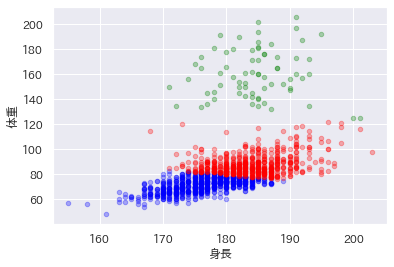

In [10]:
ax=None
plt.figure(figsize=(5,5))
for i, gd in enumerate(data.groupby('クラスタ')):
  ax = gd[1].plot(kind='scatter', x='身長', y='体重', c=colors[i], alpha=0.3, ax=ax)


必ずしも職業ごとの分布と同じグループ分ではありませんが、３つのクラスターに分類された様子が確認できました。

<div class="alert alert-warning">

クラスタリングとクラス分類

クラスタリングは、クラス分類が目的ではありません。したがって、職業等のクラス分類と異なったものになります。散布図をみると、クラスタリングは境界に曖昧なところがなく、綺麗に分類されているのが特徴です。
</div>



## エルボー法: 適切なクラスター数を調べる

エルボー法は、クラスターの重心点と所属データ点の距離の総和に着目して、クラスター数を事前に見積もる手法です。

__距離の総和の求め方__


In [11]:
print(model.inertia_)

127992.11646535949


クラスタ数を1から10まで大きくしながら、総和の変化をグラフ化してみます。

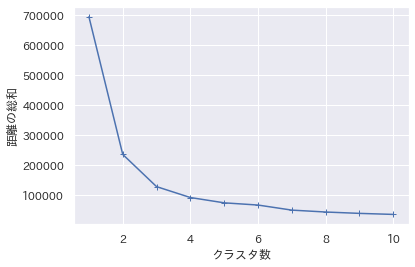

In [12]:
dist = []
for i in range(1, 11):
  km = KMeans(init='random', n_clusters=i)
  km.fit(data[['身長', '体重']])
  dist.append(km.inertia_)

plt.xlabel('クラスタ数')
plt.ylabel('距離の総和')
plt.plot(range(1, 11), dist, marker='+')


クラスター数が適切になるまでは、総和は相応に減少することが期待できます。
一方、いったん適切な数を超えてしまうと、総和の減少はなくなります。
したがって、クラスター数は2 か 3の辺りが適切なクラスター数といえます。

<div class="alert alert-info">

エルボー法の由来

適切なクラスター数がエルボー（肘）のように見えるところから

</div>

クラスター数２の散布図を調べてみよう

<Figure size 360x360 with 0 Axes>

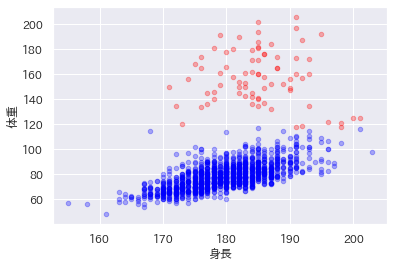

In [13]:
model = KMeans(init='random', n_clusters=2)
model.fit(data[['身長', '体重']])
data['クラスター'] = model.predict(data[['身長', '体重']])
ax=None
plt.figure(figsize=(5,5))
for i, gd in enumerate(data.groupby('クラスター')):
  ax = gd[1].plot(kind='scatter', x='身長', y='体重', c=colors[i], alpha=0.3, ax=ax)



## 乳がんデータと主成分分析

乳がんデータセットは、Breast Cancer Wisconsin (Diagnostic) Data Setに由来し、乳腺腫瘤の穿刺吸引細胞診のデジタル画像から計算されたデータです。


<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/e/ensekitt/20181102/20181102002649.jpg" width="40%"/>

1993 W.N. Street, W.H. Wolberg and O.L. Mangasarian
Nuclear feature extraction for breast tumor diagnosis 
IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993. (abstract)
Figure2 図中一部を引用

乳がんのデータを使って主成分分析も試していきます。

__データの用意__

```
!wget https://KuramitsuLab.github.io/data/cancer_ja.csv
```

オリジナルデータを日本語化したデータを用意しました。
良性は`1`、悪性は`0`のフラグがついています。


In [14]:
import pandas as pd
data = pd.read_csv('cancer_ja.csv')
data.head()

,良性,平均半径,平均感触,平均周囲長,平均面積,平均平滑性,平均密集度,平均凹部,平均凹点,平均対称性,...,最悪半径,最悪感触,最悪周囲長,最悪半径.1,最悪平滑さ,最悪密集度,最悪凹部,最悪凹点,最悪対称性,最悪フラクタル次元
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### データの理解

データの統計量を調べたり、可視化して、データの特徴を捉えましょう。

<div class="alert alert-info">

Let's try

良性がんと悪性がんの分布に法則性があるか調べてみましょう

</div>

良性か悪性かで色分けして、分布図を書いてみます。属性の組み合わせは、自由に変えて試してみましょう。


<Figure size 360x360 with 0 Axes>

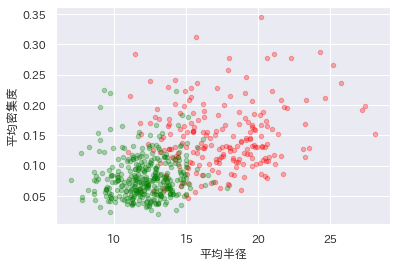

In [15]:
colors = ['red', 'green']
plt.figure(figsize=(5,5))
ax=None
for i, gd in enumerate(data.groupby('良性')):
  ax = gd[1].plot(kind='scatter', x='平均半径', y='平均密集度', c=colors[i], alpha=0.3, ax=ax)


三次元の散布図を作成したいときは、`Axes3D`をインポートして用います。

<ipython-input-16-7cb9e5290179>:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


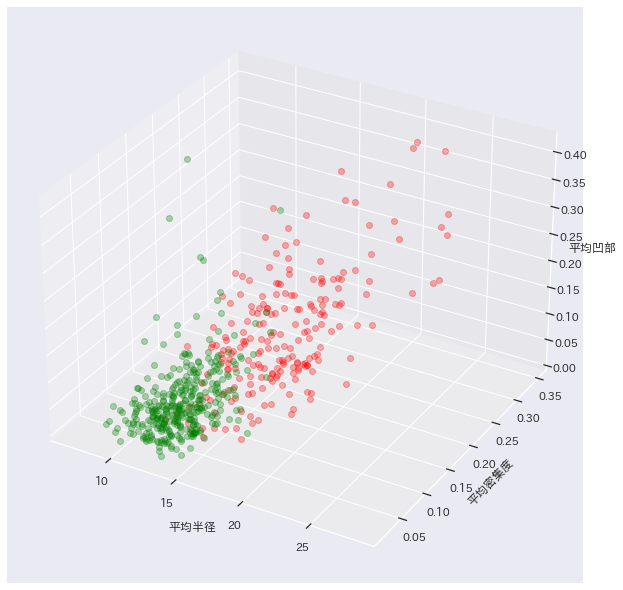

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.set_xlabel("平均半径")
ax.set_ylabel("平均密集度")
ax.set_zlabel("平均凹部")
for i, gd in enumerate(data.groupby('良性')):
    ax.plot(gd[1]['平均半径'],gd[1]['平均密集度'],gd[1]['平均凹部'],marker="o",linestyle='None',c=colors[i], alpha=0.3)


### 次元削減

乳がんデータは、30次元の変数からなります。
データの特徴を残しながら次元を削減し、表示してみます。
このとき、活用するのが**主成分分析(PCA)**です。

__主成分分析(PCA)による2次元への圧縮__


In [17]:
from sklearn.decomposition import PCA

data_x = data[data.columns[1:]]

pca = PCA(n_components=2)
pca.fit(data_x)

print('固有ベクトル: ', pca.components_)
print('分散:', pca.explained_variance_)
print('分散割合:', pca.explained_variance_ratio_)

固有ベクトル:  [[ 5.08623202e-03  2.19657026e-03  3.50763298e-02  5.16826469e-01
   4.23694535e-06  4.05260047e-05  8.19399539e-05  4.77807775e-05
   7.07804332e-06 -2.62155251e-06  3.13742507e-04 -6.50984008e-05
   2.23634150e-03  5.57271669e-02 -8.05646029e-07  5.51918197e-06
   8.87094462e-06  3.27915009e-06 -1.24101836e-06 -8.54530832e-08
   7.15473257e-03  3.06736622e-03  4.94576447e-02  8.52063392e-01
   6.42005481e-06  1.01275937e-04  1.68928625e-04  7.36658178e-05
   1.78986262e-05  1.61356159e-06]
 [ 9.28705650e-03 -2.88160658e-03  6.27480827e-02  8.51823720e-01
  -1.48194356e-05 -2.68862249e-06  7.51419574e-05  4.63501038e-05
  -2.52430431e-05 -1.61197148e-05 -5.38692831e-05  3.48370414e-04
   8.19640791e-04  7.51112451e-03  1.49438131e-06  1.27357957e-05
   2.86921009e-05  9.36007477e-06  1.22647432e-05  2.89683790e-07
  -5.68673345e-04 -1.32152605e-02 -1.85961117e-04 -5.19742358e-01
  -7.68565692e-05 -2.56104144e-04 -1.75471479e-04 -3.05051743e-05
  -1.57042845e-04 -5.53071662e-0

__主成分分析の結果__

* **固有ベクトル**: `pca.components_`: 新しい特徴空間の軸の向き
* **各主成分の分散**: `pca.explained_variance_` 
* **各主成分の持つ分散割合**: `pca.explained_variance_ratio_`: 第一主成分で98%の情報を保持

さて、主成分分析の結果を用いて乳がんデータを変換しましょう。

In [18]:
data_pca = pca.transform(data_x)  #　主成分分析による変換
print('data_std(shape):', data_x.shape)
print('data_pca(shape):', data_pca.shape)

data_std(shape): (569, 30)
data_pca(shape): (569, 2)


30次元のデータが2次元に削減されていることが確認できるはずです。
なお、`transform()`で得られるデータは、
NumPyの2次元配列なので、表データに変換して、`data_pca`としておきます。

In [19]:
pd.DataFrame(data_pca, columns=['pc1', 'pc2']).head()

,pc1,pc2
0,1160.142574,-293.917544
1,1269.122443,15.630182
2,995.793889,39.156743
3,-407.180803,-67.380320
4,930.341180,189.340742


In [20]:
data_pca = pd.concat([pd.DataFrame(data_pca, columns=['pc1', 'pc2']), data], axis=1)
data_pca.head()

,pc1,pc2,良性,平均半径,平均感触,平均周囲長,平均面積,平均平滑性,平均密集度,平均凹部,...,最悪半径,最悪感触,最悪周囲長,最悪半径.1,最悪平滑さ,最悪密集度,最悪凹部,最悪凹点,最悪対称性,最悪フラクタル次元
0,1160.142574,-293.917544,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1269.122443,15.630182,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,995.793889,39.156743,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,-407.180803,-67.380320,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,930.341180,189.340742,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


第一主成分(pc1)をx軸、第二主成分(pc2)をy軸として散布図を書いてみます。

<Figure size 360x360 with 0 Axes>

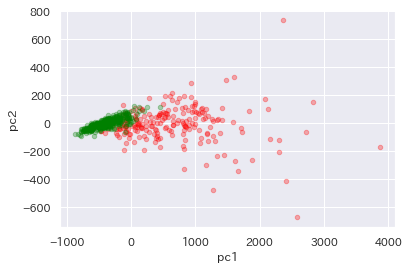

In [21]:
plt.figure(figsize=(5,5))
ax=None
for i, gd in enumerate(data_pca.groupby('良性')):
  ax = gd[1].plot(kind='scatter', x='pc1', y='pc2', c=colors[i], alpha=0.3, ax=ax)

### スケーリング：標準化

乳がんデータは、さまざまな属性が含まれており、単位が異なります。最大値や最小値も大きくばらついています。

In [22]:
data.describe()

,良性,平均半径,平均感触,平均周囲長,平均面積,平均平滑性,平均密集度,平均凹部,平均凹点,平均対称性,...,最悪半径,最悪感触,最悪周囲長,最悪半径.1,最悪平滑さ,最悪密集度,最悪凹部,最悪凹点,最悪対称性,最悪フラクタル次元
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.627417,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,1.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


データ分析では、大きな値の属性があると、分析結果は小さな値の属性の影響が小さくなります。そのような影響を排除するため、スケーリング（標準化）は常套手段です。

__標準化__: サンプル値$x$から平均$\bar{x}$を引き、標準偏差$\sigma$で割る

$$
z = \frac{x - \bar{x}}{\sigma}
$$

sklearnモジュールでは、StandardScaler クラスとして提供されています。
使用法は、PCAクラスと同じで、モデルを学習し、その後、変換します。

__StandardScalerによる標準化__

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# print(data.columns) カラム名
sc.fit(data[data.columns[1:]])

# 標準化
data_std = sc.transform(data[data.columns[1:]])
pd.DataFrame(data_std, columns=data.columns[1:]).head()

,平均半径,平均感触,平均周囲長,平均面積,平均平滑性,平均密集度,平均凹部,平均凹点,平均対称性,平均フラクタル次元,...,最悪半径,最悪感触,最悪周囲長,最悪半径.1,最悪平滑さ,最悪密集度,最悪凹部,最悪凹点,最悪対称性,最悪フラクタル次元
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


標準化したデータセットに対し、主成分分析をしてみましょう。

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data_std)
data_pca = pca.transform(data_std)
print('data_std(shape):', data_std.shape)
print('data_pca(shape):', data_pca.shape)


data_std(shape): (569, 30)
data_pca(shape): (569, 2)


In [25]:
data = pd.concat([pd.DataFrame(data_pca, columns=['pc1', 'pc2']), data], axis=1)
data.head()

,pc1,pc2,良性,平均半径,平均感触,平均周囲長,平均面積,平均平滑性,平均密集度,平均凹部,...,最悪半径,最悪感触,最悪周囲長,最悪半径.1,最悪平滑さ,最悪密集度,最悪凹部,最悪凹点,最悪対称性,最悪フラクタル次元
0,9.192837,1.948583,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,2.387802,-3.768172,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,5.733896,-1.075174,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,7.122953,10.275589,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,3.935302,-1.948072,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<Figure size 360x360 with 0 Axes>

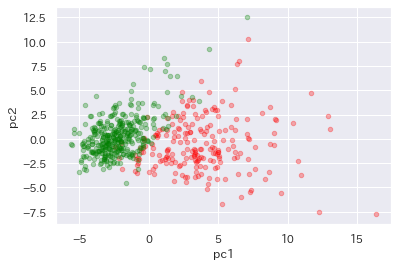

In [26]:
plt.figure(figsize=(5,5))
ax=None
for i, gd in enumerate(data.groupby('良性')):
  ax = gd[1].plot(kind='scatter', x='pc1', y='pc2', c=colors[i], alpha=0.3, ax=ax)

<div class="alert alert-info">

Let's try

標準化した乳がんデータセットに対して、k-means法でクラスタリングしてみよう。

</div>

## コースワーク

<div class="admonition tip">

**例題（成績表）**

基本情報処理でおなじみの成績データを用いて、３グループに分割してみよう。

1. 成績順にソートしてグループ分けする (属性名: `成績G`)
2. k-means 法でグループに分類する (属性名: `K平均G`)
3. 英数国社理を、理系/文系科目の２次元に減らし、k-means法でグループ分けする
4. 主成分分析を用いて２次元に削減したのち、k-means法でグループ分けする

それぞれのグループ分けの結果を散布図でグラフ化し、特徴など気づいたことを議論してみよう。

</div>

__データ__

次のテキストデータからCSVファイルを作成して作業しましょう。

```
%%file 成績.csv
名前,英,数,国,社,理
佐藤,84,45,77,69,48
鈴木,75,69,65,77,69
高橋,69,81,45,82,79
田中,92,75,83,79,62
伊藤,62,91,68,61,93
渡辺,54,63,48,52,50
山本,48,53,71,83,45
中村,77,85,62,55,82
小林,82,88,89,79,85
加藤,47,48,57,53,63
吉田,75,36,85,73,51
山田,66,73,79,65,66
佐々木,64,95,48,59,91
山口,73,86,52,70,77
松本,55,75,63,67,80
```
